In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
dataDirectory = "Indian Food Images\Indian Food Images"

In [5]:
subdirectories = [subdir for subdir in os.listdir(dataDirectory) if os.path.isdir(os.path.join(dataDirectory, subdir))]

print(f"Number of subdirectories: {len(subdirectories)}")
print(f"Subdirectories: {subdirectories}")

Number of subdirectories: 80
Subdirectories: ['adhirasam', 'aloo_gobi', 'aloo_matar', 'aloo_methi', 'aloo_shimla_mirch', 'aloo_tikki', 'anarsa', 'ariselu', 'bandar_laddu', 'basundi', 'bhatura', 'bhindi_masala', 'biryani', 'boondi', 'butter_chicken', 'chak_hao_kheer', 'cham_cham', 'chana_masala', 'chapati', 'chhena_kheeri', 'chicken_razala', 'chicken_tikka', 'chicken_tikka_masala', 'chikki', 'daal_baati_churma', 'daal_puri', 'dal_makhani', 'dal_tadka', 'dharwad_pedha', 'doodhpak', 'double_ka_meetha', 'dum_aloo', 'gajar_ka_halwa', 'gavvalu', 'ghevar', 'gulab_jamun', 'imarti', 'jalebi', 'kachori', 'kadai_paneer', 'kadhi_pakoda', 'kajjikaya', 'kakinada_khaja', 'kalakand', 'karela_bharta', 'kofta', 'kuzhi_paniyaram', 'lassi', 'ledikeni', 'litti_chokha', 'lyangcha', 'maach_jhol', 'makki_di_roti_sarson_da_saag', 'malapua', 'misi_roti', 'misti_doi', 'modak', 'mysore_pak', 'naan', 'navrattan_korma', 'palak_paneer', 'paneer_butter_masala', 'phirni', 'pithe', 'poha', 'poornalu', 'pootharekulu', '

## Data Preprocessing for Deep Learning

I performed the following steps:<br><br>
**1. Resizing**<br>
**2. Normalizing the Dataset**<br>
**3. Data Augmentation**

In [6]:
datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values to be between 0 and 1
    rotation_range=20,       # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,   # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.2,  # Randomly shift images vertically by up to 20% of the height
    shear_range=0.2,         
    zoom_range=0.2,        
    horizontal_flip=True,    
    vertical_flip=False,     
    fill_mode='nearest'      
)

batchSize = 32
dataGenerator = datagen.flow_from_directory(
    dataDirectory,
    target_size=(200, 200),   # Resize images to 200x200 pixels
    batch_size=batchSize,
    class_mode='categorical'  
)

augmentedImages, _ = next(dataGenerator)

Found 4000 images belonging to 80 classes.


In [7]:
imageHeight,imageWidth=200,200 
batchSize=32

### Splitting the Dataset into Training Dataset and Validation Dataset

In [8]:
trainDataset = tf.keras.preprocessing.image_dataset_from_directory(
  dataDirectory,
  validation_split=0.2,
  subset="training",
  seed=35,
  image_size=(imageHeight, imageWidth),
  batch_size=batchSize)

Found 4000 files belonging to 80 classes.
Using 3200 files for training.


In [9]:
validationDataset = tf.keras.preprocessing.image_dataset_from_directory(
  dataDirectory,
  validation_split=0.2,
  subset="validation",
  seed=35,
  image_size=(imageHeight, imageWidth),
  batch_size=batchSize)

Found 4000 files belonging to 80 classes.
Using 800 files for validation.


### Visualizing the images

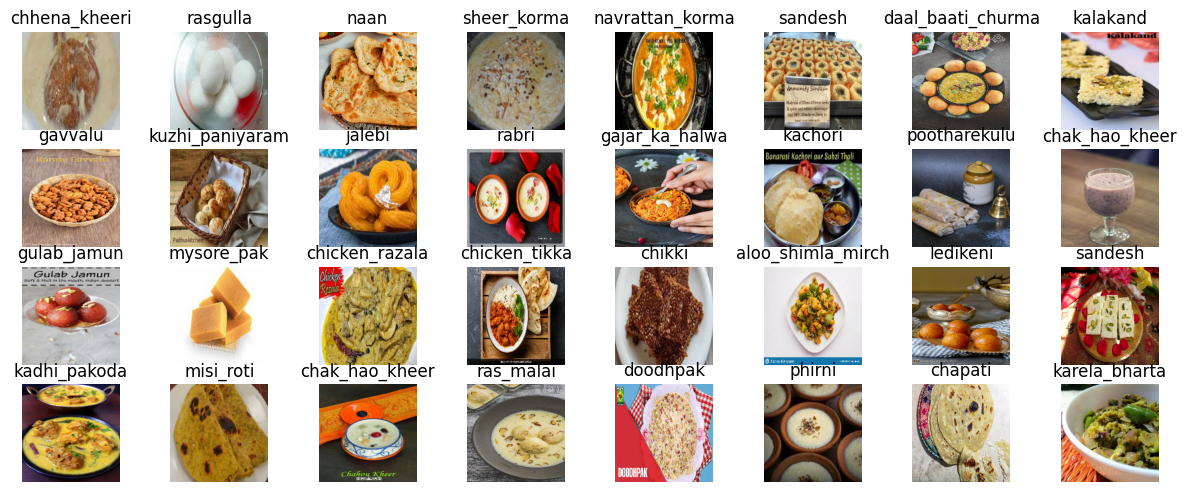

In [10]:
classNames = trainDataset.class_names

plt.figure(figsize=(15, 15))
for images, labels in trainDataset.take(1): 
    for i in range(min(80, batchSize)): 
        ax = plt.subplot(10, 8, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classNames[labels[i]])
        plt.axis("off")
plt.show()

---
## Implementation of the ResNet Model

In [11]:
resnetModel = Sequential()

pretrainedModel= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(200,200,3),
                   pooling='avg',classes=80,
                   weights='imagenet')
for layer in pretrainedModel.layers:
        layer.trainable=False

resnetModel.add(pretrainedModel)
resnetModel.add(Flatten())
resnetModel.add(Dense(1024, activation='relu'))
resnetModel.add(Dense(512, activation='relu'))
resnetModel.add(Dense(80, activation='softmax'))

In [12]:
resnetModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 module_wrapper (ModuleWrap  (None, 2048)              0         
 per)                                                            
                                                                 
 module_wrapper_1 (ModuleWr  (None, 1024)              2098176   
 apper)                                                          
                                                                 
 module_wrapper_2 (ModuleWr  (None, 512)               524800    
 apper)                                                          
                                                                 
 module_wrapper_3 (ModuleWr  (None, 80)                41040     
 apper)                                                 

In [13]:
resnetModel.compile(optimizer=Adam(learning_rate=0.0001), 
                     loss='sparse_categorical_crossentropy', 
                     metrics=['accuracy'])

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
csv_logger = CSVLogger('ResNet50_Training_History.csv')
epochs=15
history = resnetModel.fit(
  trainDataset,
  validation_data=validationDataset,
  epochs=epochs,
  callbacks=[early_stopping, reduce_lr])  

Epoch 1/15


100/100 [==============================] - 131s 1s/step - loss: 4.1296 - accuracy: 0.0897 - val_loss: 3.7143 - val_accuracy: 0.1612 - lr: 1.0000e-04
Epoch 2/15
100/100 [==============================] - 126s 1s/step - loss: 2.9850 - accuracy: 0.3219 - val_loss: 2.9641 - val_accuracy: 0.2537 - lr: 1.0000e-04
Epoch 3/15
100/100 [==============================] - 127s 1s/step - loss: 2.1444 - accuracy: 0.4875 - val_loss: 2.5738 - val_accuracy: 0.3187 - lr: 1.0000e-04
Epoch 4/15
100/100 [==============================] - 158s 2s/step - loss: 1.5907 - accuracy: 0.6162 - val_loss: 2.3399 - val_accuracy: 0.3900 - lr: 1.0000e-04
Epoch 5/15
100/100 [==============================] - 157s 2s/step - loss: 1.1950 - accuracy: 0.7328 - val_loss: 2.2479 - val_accuracy: 0.3988 - lr: 1.0000e-04
Epoch 6/15
100/100 [==============================] - 137s 1s/step - loss: 0.9114 - accuracy: 0.8150 - val_loss: 2.0932 - val_accuracy: 0.4462 - lr: 1.0000e-04
Epoch 7/15
100/100 [==================

### Visualization

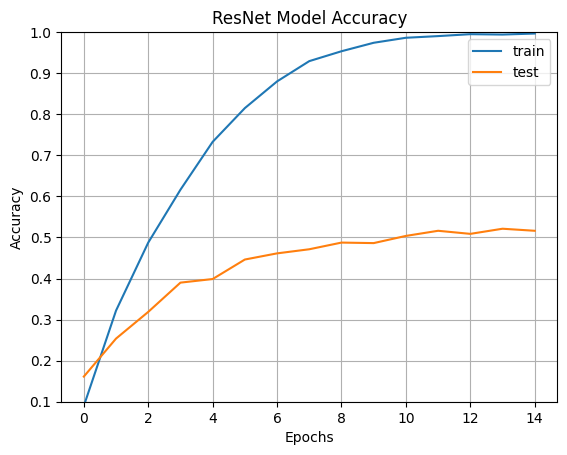

In [15]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.1,ymax=1)
plt.grid()
plt.title('ResNet Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.savefig('ResNet_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

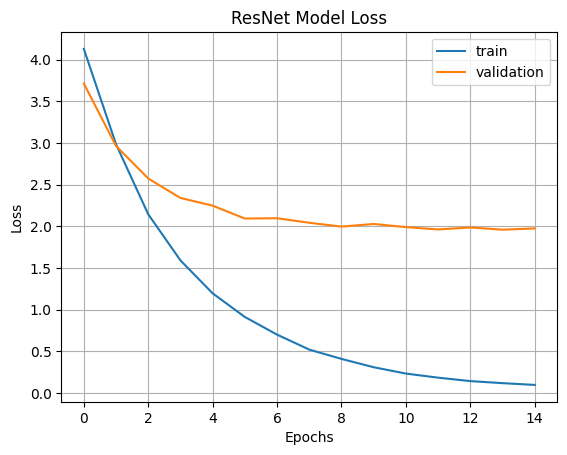

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('ResNet Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [22]:
resnetModel.save_weights("indian_food_resnet50.weights.h5")

## Evaluation of the ResNet Model

In [27]:
resnet_model_evaluation = resnetModel.evaluate(validationDataset)

print("ResNet Model Evaluation:")
print("Test Loss:", resnet_model_evaluation[0])
print("Test Accuracy:", resnet_model_evaluation[1])

25/25 [==============================] - 33s 1s/step - loss: 1.9664 - accuracy: 0.5350
ResNet Model Evaluation:
Test Loss: 1.966442584991455
Test Accuracy: 0.5350000262260437


In [23]:
# ===============================
# SAVE MODEL IN SAVEDMODEL FORMAT
# ===============================

import tensorflow as tf

# This creates a folder (this is correct)
resnetModel.save(
    "indian_food_resnet50_savedmodel",
    save_format="tf"
)

print("✅ Model saved successfully in SavedModel format")

INFO:tensorflow:Assets written to: indian_food_resnet50_savedmodel\assets


INFO:tensorflow:Assets written to: indian_food_resnet50_savedmodel\assets


✅ Model saved successfully in SavedModel format


In [24]:
import json

with open("class_names.json", "w") as f:
    json.dump(trainDataset.class_names, f)

print("✅ class_names.json saved")

✅ class_names.json saved


## Evaluation of the VGG16 Model

In [28]:
vgg16_model_evaluation = vgg_16_model.evaluate(validationDataset)

print("VGG16 Model Evaluation:")
print("Test Loss:", vgg16_model_evaluation[0])
print("Test Accuracy:", vgg16_model_evaluation[1])

25/25 [==============================] - 102s 4s/step - loss: 2.7705 - accuracy: 0.4187
VGG16 Model Evaluation:
Test Loss: 2.7705307006835938
Test Accuracy: 0.41874998807907104


In [29]:
# Convert test labels to class labels
testLabels = []
for images, labels in validationDataset:
    testLabels.extend(labels.numpy())

testLabels = np.array(testLabels)

## Result Analysis of the ResNet Model

25/25 [==============================] - 33s 1s/step


C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


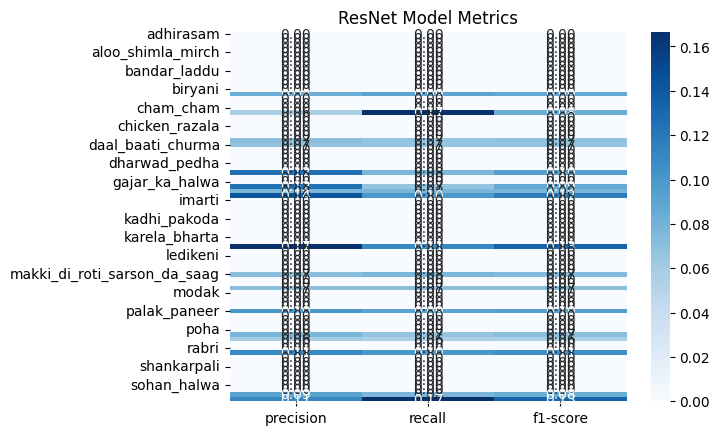

In [44]:
import pandas as pd

resnet_predictions = resnetModel.predict(validationDataset)
resnet_pred_labels = np.argmax(resnet_predictions, axis=1)
report = classification_report(testLabels, resnet_pred_labels, target_names=classNames, output_dict=True)

# Plot precision, recall, and F1-score
metrics_df = pd.DataFrame(report).transpose()
metrics_df.drop(['accuracy', 'macro avg', 'weighted avg'], inplace=True)
sns.heatmap(metrics_df[['precision', 'recall', 'f1-score']], annot=True, cmap='Blues', fmt=".2f")
plt.title('ResNet Model Metrics')
plt.show()

## Result Analysis of the VGG16 Model

25/25 [==============================] - 86s 3s/step


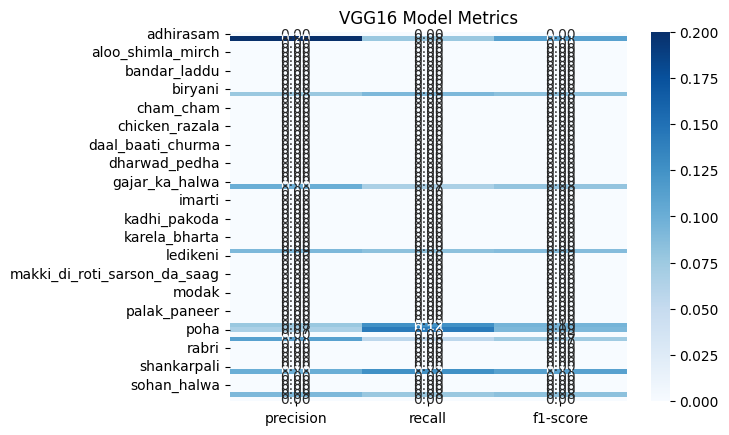

In [45]:
import pandas as pd
import seaborn as sns

vgg16_predictions = vgg_16_model.predict(validationDataset)
vgg16_pred_labels = np.argmax(vgg16_predictions, axis=1)
report = classification_report(testLabels, vgg16_pred_labels, target_names=classNames, output_dict=True)

# Plot precision, recall, and F1-score
metrics_df = pd.DataFrame(report).transpose()
metrics_df.drop(['accuracy', 'macro avg', 'weighted avg'], inplace=True)
sns.heatmap(metrics_df[['precision', 'recall', 'f1-score']], annot=True, cmap='Blues', fmt=".2f")
plt.title('VGG16 Model Metrics')
plt.show()

---
## Conclusion

After a comprehensive assessment of both the VGG16 and ResNet models applied to the Indian Food dataset, a clear trend emerges favoring the ResNet architecture over VGG16. The ResNet model showcases superior performance in key metrics such as accuracy, precision, recall, and F1-score, attesting to its capability to discern and classify Indian food items more accurately. This proficiency is attributed to ResNet's adeptness at capturing intricate features and patterns within the dataset.

While the ResNet model exhibits superior overall performance, it's essential to acknowledge that certain features were better predicted by the VGG16 model, as evidenced by the heatmap metrics. This nuanced observation suggests that each model has its strengths, and the choice between them may depend on the specific characteristics of the features under consideration.

In summary, while the ResNet model demonstrates overall superiority, the nuanced strengths of the VGG16 model in certain aspects underscore the importance of careful consideration and potentially exploring ensemble approaches to harness the complementary strengths of both architectures.